**Q1.** Load `./data/Q1_clean.csv`. The data include

- `Price` per night
- `Review Scores Rating`: The average rating for the property
- `Neighbourhood `: The bourough of NYC. Note the space, or rename the variable.
- `Property Type`: The kind of dwelling
- `Room Type`: The kind of space being rented

1. Compute the average prices and scores by `Neighbourhood `; which bourough is the most expensive on average? Create a kernel density plot of price and log price, grouping by `Neighbourhood `.


In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

df = pd.read_csv( "/workspace/linearRegression/data/Q1_clean.csv" )

# find average price for each neighborhood
average_prices = df.groupby('Neighbourhood ')['Price'].mean()
print( average_prices ) # manhattan has the most expensive prices, on average
print( "\n" )

df['Log_Price'] = np.log(df['Price'])
log_prices = df.groupby('Neighbourhood ')['Log_Price'].mean()
print( log_prices )

Neighbourhood 
Bronx             75.276498
Brooklyn         127.747378
Manhattan        183.664286
Queens            96.857233
Staten Island    146.166667
Name: Price, dtype: float64


Neighbourhood 
Bronx            4.204151
Brooklyn         4.684422
Manhattan        5.042073
Queens           4.441535
Staten Island    4.394030
Name: Log_Price, dtype: float64


<Axes: xlabel='Price', ylabel='Density'>

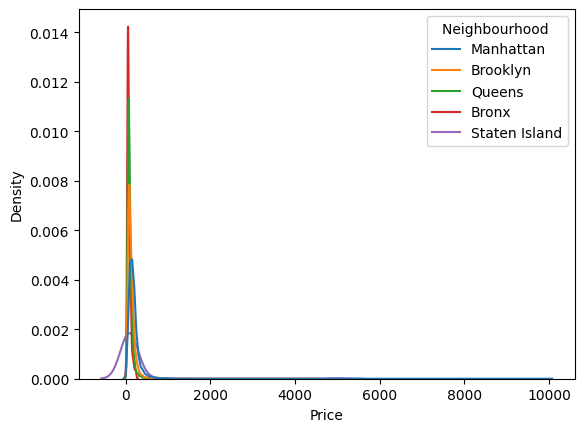

In [2]:
sns.kdeplot(data=df, x="Price", hue="Neighbourhood ", common_norm=False)


<Axes: xlabel='Log_Price', ylabel='Density'>

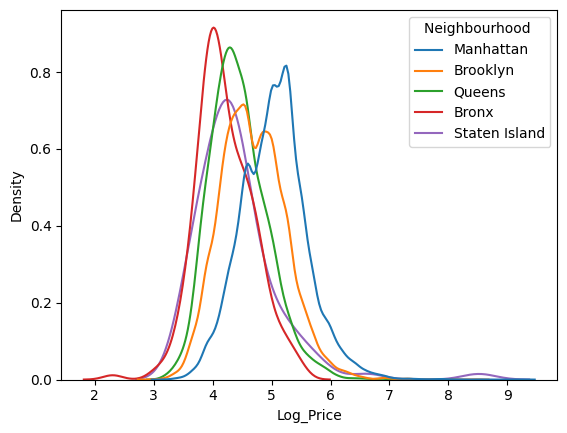

In [3]:
sns.kdeplot(data=df, x="Log_Price", hue="Neighbourhood ", common_norm=False)


2. Regress price on `Neighbourhood ` by creating the appropriate dummy/one-hot-encoded variables, without an intercept in the linear model and using all the data. Compare the coefficients in the regression to the table from part 1. What pattern do you see? What are the coefficients in a regression of a continuous variable on one categorical variable?


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

encoder = OneHotEncoder(handle_unknown='ignore')
neighbourhood_encoded = encoder.fit_transform(df[['Neighbourhood ']])

# code geenrated with help from chat gpt

X = neighbourhood_encoded
y = df['Price']
# Create the linear regression model without an intercept
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

neighbourhood_coefficients = model.coef_
neighbourhood_names = encoder.get_feature_names_out(['Neighbourhood '])

print( "Coefficients for each neighborhood:")
# Print neighborhood names along with their coefficients:
for name, coef in zip(neighbourhood_names, neighbourhood_coefficients):
    print(f"{name}: {coef}")

print( "\n" )
print( "Averages for each neighborhood:")
print(average_prices)

# we see that the amplitude of coefficients for each neighborhood mirrors the neighborhood price averages 
# (ex: Manhattan has the highest price verage and the highest coefficient)

# The coefficients in a regression of one categorical variable on a continuous variable represent the average difference between
# y values in reference to a base value

Coefficients for each neighborhood:
Neighbourhood _Bronx: 75.2764976958525
Neighbourhood _Brooklyn: 127.74737833961359
Neighbourhood _Manhattan: 183.66428634132984
Neighbourhood _Queens: 96.85723270442199
Neighbourhood _Staten Island: 146.16666666666657


Averages for each neighborhood:
Neighbourhood 
Bronx             75.276498
Brooklyn         127.747378
Manhattan        183.664286
Queens            96.857233
Staten Island    146.166667
Name: Price, dtype: float64



3. Repeat part 2, but leave an intercept in the linear model. How do you have to handle the creation of the dummies differently? What is the intercept? Interpret the coefficients. How can I get the coefficients in part 2 from these new coefficients?


In [5]:
# When leaving an intercept in the linear model, one must drop one of the categories in the OneHotEncoder. Otherwise, 
# there will be multicollinearity with the intercept (known as the dummy trap).

# the intercept is 75.27, which implies that the baseline price is 75.27, without introducing the variation in 
# price that is associated with neighborhood.

# the coefficients are lower here (compared to in the previous part). To get the coefficient values from the previous part, 
# these coefficient values to the intercept.


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
# code generated with help from chat gpt

encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
neighbourhood_encoded = encoder.fit_transform(df[['Neighbourhood ']])

X = neighbourhood_encoded
y = df['Price']
model = LinearRegression(fit_intercept=True) # Create the linear regression model with an intercept
model.fit(X, y)

neighbourhood_coefficients = model.coef_
intercept = model.intercept_

# Get the neighborhood names (with one dropped as baseline)
neighbourhood_names = encoder.get_feature_names_out(['Neighbourhood '])

# Print intercept and neighborhood coefficients
print(f"Intercept (baseline neighbourhood): {intercept}")
for name, coef in zip(neighbourhood_names, neighbourhood_coefficients):
    print(f"{name}: {coef}")


Intercept (baseline neighbourhood): 75.2764976955106
Neighbourhood _Brooklyn: 52.47088064476852
Neighbourhood _Manhattan: 108.38778862827075
Neighbourhood _Queens: 21.580735008590537
Neighbourhood _Staten Island: 70.89016897078484



4. Split the sample 80/20 into a training and a test set. Run a regression of `Price` on `Review Scores Rating` and `Neighbourhood `. What is the $R^2$ and RMSE on the test set? What is the coefficient on `Review Scores Rating`? What is the most expensive kind of property you can rent?


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Fill missing values in 'Review Scores Rating' and 'Price'
df['Review Scores Rating'].fillna(df['Review Scores Rating'].mean(), inplace=True)
df['Price'].fillna(df['Price'].mean(), inplace=True)

# Fill missing values in 'Neighbourhood ' with 'Unknown' (keeping the trailing space)
df['Neighbourhood '].fillna('Unknown', inplace=True)

# Split the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Encode 'Neighbourhood ' using one-hot encoding, with one category dropped for the baseline
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
neighbourhood_encoded_train = encoder.fit_transform(train_df[['Neighbourhood ']])
neighbourhood_encoded_test = encoder.transform(test_df[['Neighbourhood ']])

# Create the feature matrix for both training and test sets
X_train = np.hstack([train_df[['Review Scores Rating']].values, neighbourhood_encoded_train.toarray()])
X_test = np.hstack([test_df[['Review Scores Rating']].values, neighbourhood_encoded_test.toarray()])
y_train = train_df['Price']
y_test = test_df['Price']

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate R^2 and RMSE on the test set
r_squared = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Retrieve the coefficient for 'Review Scores Rating'
review_scores_rating_coef_1 = model.coef_[0]

# Find the neighborhood with the highest positive coefficient, indicating the most expensive neighborhood
neighbourhood_names = encoder.get_feature_names_out(['Neighbourhood '])
most_expensive_neighbourhood = neighbourhood_names[np.argmax(model.coef_[1:])]  # Ignore the first coefficient (Review Scores Rating)

# Output results
print(f"R^2 on the test set: {r_squared}")
print(f"RMSE on the test set: {rmse}")
print(f"Coefficient for Review Scores Rating: {review_scores_rating_coef_1}")
print(f"The most expensive neighborhood to rent a property is: {most_expensive_neighbourhood}")



R^2 on the test set: 0.045925883817350965
RMSE on the test set: 140.91821103729345
Coefficient for Review Scores Rating: 1.2118517840632352
The most expensive neighborhood to rent a property is: Neighbourhood _Manhattan


/tmp/ipykernel_5117/223375268.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Review Scores Rating'].fillna(df['Review Scores Rating'].mean(), inplace=True)
/tmp/ipykernel_5117/223375268.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].m


5. Split the sample 80/20 into a training and a test set. Run a regression of `Price` on `Review Scores Rating` and `Neighbourhood ` and `Property Type`. What is the $R^2$ and RMSE on the test set? What is the coefficient on `Review Scores Rating`? What is the most expensive kind of property you can rent?


In [7]:
# code generated with help from chat gpt:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Encode 'Neighbourhood' and 'Property Type' using one-hot encoding, with one category dropped for each
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
combined_encoded_train = encoder.fit_transform(train_df[['Neighbourhood ', 'Property Type']])
combined_encoded_test = encoder.transform(test_df[['Neighbourhood ', 'Property Type']])

# Create the feature matrix for both training and test sets
X_train = np.hstack([train_df[['Review Scores Rating']].values, combined_encoded_train.toarray()])
X_test = np.hstack([test_df[['Review Scores Rating']].values, combined_encoded_test.toarray()])
y_train = train_df['Price']
y_test = test_df['Price']

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate R^2 and RMSE on the test set
r_squared = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Retrieve the coefficient for 'Review Scores Rating'
review_scores_rating_coef_2 = model.coef_[0]

# Get the feature names for both neighborhoods and property types
feature_names = encoder.get_feature_names_out(['Neighbourhood ', 'Property Type'])

# Determine the most expensive property type by finding the maximum positive coefficient among property types
property_type_coefficients = model.coef_[1 + len(encoder.categories_[0]):]  # Skip 'Review Scores Rating' and 'Neighbourhood' coefficients
most_expensive_property_index = np.argmax(property_type_coefficients)
most_expensive_property = encoder.categories_[1][1:][most_expensive_property_index]  # Adjust indexing for property type names

# Output results
print(f"R^2 on the test set: {r_squared}")
print(f"RMSE on the test set: {rmse}")
print(f"Coefficient for Review Scores Rating: {review_scores_rating_coef_2}")
print(f"The most expensive type of property to rent is: {most_expensive_property}")

# the R^2 on the test set is 0.054, which is very low. This implies that only 5% of the variation in price can be explained 
# by review scores rating, neighborhood, and property type.

# the RMSE on the test set is 140.30, which implies a very large deviation between actual price values and those predicted by the model.

# the coefficient on review scores rating is 1.2. This implies that for every point added to review score, the price of
# renting a proporty increases by that amount.

# The most expensive type of proporaty that one can rent (according to price average) is a boat.

R^2 on the test set: 0.054242713551245325
RMSE on the test set: 140.30266238276283
Coefficient for Review Scores Rating: 1.2010106602298556
The most expensive type of property to rent is: Boat



6. What does the coefficient on `Review Scores Rating` mean if it changes from part 4 to 5? Hint: Think about how multilple linear regression works.


In [8]:
# the coefficient on review scores for the first regression is 1.21, vs a coefficient of 1.20 for the second regression. This
# is a very minimal change. The change is caused by the introduction of "property type" as a variable in the second model,
# which "draws out" some of the variation in price related to review score.


7. (Optional) We've included `Neighborhood ` and `Property Type` separately in the model. How do you interact them, so you can have "A bedroom in Queens" or "A townhouse in Manhattan". Split the sample 80/20 into a training and a test set and run a regression including that kind of "property type X neighborhood" dummy, plus `Review Scores Rating`. How does the slope coefficient for `Review Scores Rating`, the $R^2$, and the RMSE change? Do they increase significantly compares to part 5? Are the coefficients in this regression just the sum of the coefficients for `Neighbourhood ` and `Property Type` from 5? What is the most expensive kind of property you can rent?

**Q5.**
1. Find a dataset on a topic you're interested in. Some easy options are data.gov, kaggle.com, and data.world.


In [9]:
# importing a plane dataset which includes flight times (timestamp as well as month and date), delay times, & departure time, etc.

df = pd.read_csv( "/workspace/linearRegression/data/flights.csv" )



2. Clean the data and do some exploratory data analysis on key variables that interest you. Pick a particular target/outcome variable and features/predictors.


In [10]:
# clean the data:

print( df.head() )
# drop nulls if they exist:
df.dropna()

   id  year  month  day  dep_time  sched_dep_time  dep_delay  arr_time  \
0   0  2013      1    1     517.0             515        2.0     830.0   
1   1  2013      1    1     533.0             529        4.0     850.0   
2   2  2013      1    1     542.0             540        2.0     923.0   
3   3  2013      1    1     544.0             545       -1.0    1004.0   
4   4  2013      1    1     554.0             600       -6.0     812.0   

   sched_arr_time  arr_delay  ... flight  tailnum origin dest air_time  \
0             819       11.0  ...   1545   N14228    EWR  IAH    227.0   
1             830       20.0  ...   1714   N24211    LGA  IAH    227.0   
2             850       33.0  ...   1141   N619AA    JFK  MIA    160.0   
3            1022      -18.0  ...    725   N804JB    JFK  BQN    183.0   
4             837      -25.0  ...    461   N668DN    LGA  ATL    116.0   

   distance  hour  minute            time_hour                    name  
0      1400     5      15  2013-01-01

,id,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,...,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour,name
0,0,2013,1,1,517.0,515,2.0,830.0,819,11.0,...,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01 05:00:00,United Air Lines Inc.
1,1,2013,1,1,533.0,529,4.0,850.0,830,20.0,...,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01 05:00:00,United Air Lines Inc.
2,2,2013,1,1,542.0,540,2.0,923.0,850,33.0,...,1141,N619AA,JFK,MIA,160.0,1089,5,40,2013-01-01 05:00:00,American Airlines Inc.
3,3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,...,725,N804JB,JFK,BQN,183.0,1576,5,45,2013-01-01 05:00:00,JetBlue Airways
4,4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,...,461,N668DN,LGA,ATL,116.0,762,6,0,2013-01-01 06:00:00,Delta Air Lines Inc.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336765,336765,2013,9,30,2240.0,2245,-5.0,2334.0,2351,-17.0,...,1816,N354JB,JFK,SYR,41.0,209,22,45,2013-09-30 22:00:00,JetBlue Airways
336766,336766,2013,9,30,2240.0,2250,-10.0,2347.0,7,-20.0,...,2002,N281JB,JFK,BUF,52.0,301,22,50,2013-09-30 22:00:00,JetBlue Airways
336767,336767,2013,9,30,2241.0,2246,-5.0,2345.0,1,-16.0,...,486,N346JB,JFK,ROC,47.0,264,22,46,2013-09-30 22:00:00,JetBlue Airways
336768,336768,2013,9,30,2307.0,2255,12.0,2359.0,2358,1.0,...,718,N565JB,JFK,BOS,33.0,187,22,55,2013-09-30 22:00:00,JetBlue Airways


Summary stats for arrival delay: 

count    327346.000000
mean          6.895377
std          44.633292
min         -86.000000
25%         -17.000000
50%          -5.000000
75%          14.000000
max        1272.000000
Name: arr_delay, dtype: float64 



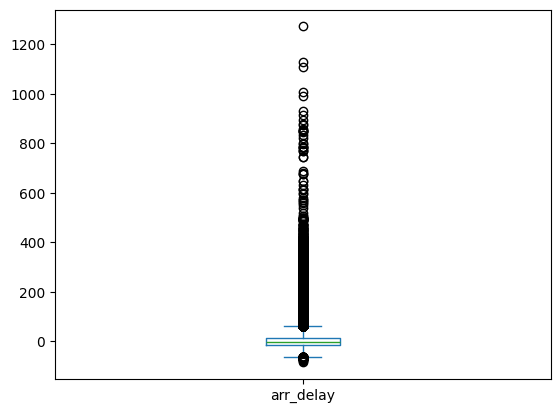

In [11]:
# looking at flight delay (for flight arrival). Arrival delay is calculated in minutes, with a positive value indicating a delay, and
# a negative value indicating that the flight arrrived ahead of schedule:

print( "Summary stats for arrival delay: \n")
summary_delay = df[ "arr_delay" ].describe()
print( summary_delay, "\n" )
# the mean flight delay was 6.89 minutes, whereas the median departure delay was -5 minutes (aka: 5 minutes ahead of schedule). This could
# indicate that large outliers are influencing the mean
ax = df["arr_delay"].plot.box()
# in this boxplot, we see a large number of positive outliers. 

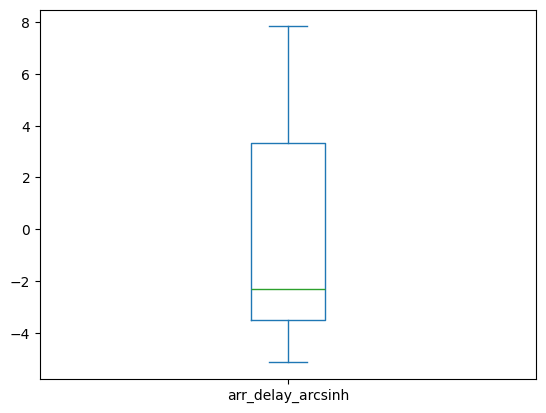

In [12]:


df["arr_delay_arcsinh"] = np.arcsinh(df["arr_delay"])
ax = df["arr_delay_arcsinh"].plot.box()
# applying arsinh removed the outliers.


Summary stats for departure delay: 

count    328521.000000
mean         12.639070
std          40.210061
min         -43.000000
25%          -5.000000
50%          -2.000000
75%          11.000000
max        1301.000000
Name: dep_delay, dtype: float64 



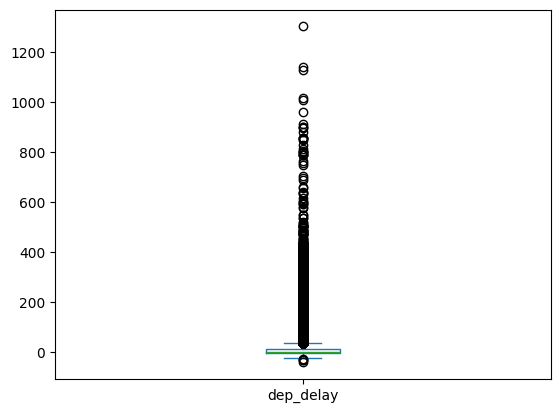

In [13]:

# doing the same thing for departure delay:
print( "Summary stats for departure delay: \n")
summary_delay = df[ "dep_delay" ].describe()
print( summary_delay, "\n" )

ax = df["dep_delay"].plot.box()
# we see many outliers here as well
# perform cleaning using arcsinh transformation:
df["arr_delay_arcsinh"] = np.arcsinh(df["arr_delay"])



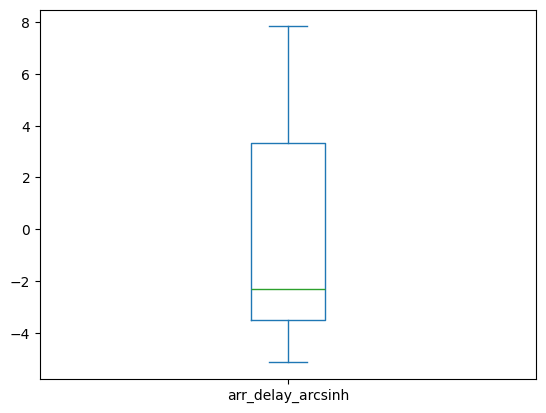

In [14]:
ax = df["arr_delay_arcsinh"].plot.box() # plot the transformed departure delay distribution
# outliers removed

<Axes: xlabel='sched_dep_time', ylabel='dep_delay'>

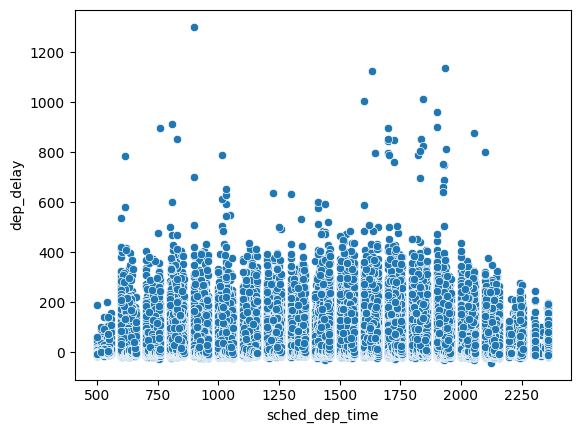

In [15]:
# look at the correlation between scheduled departure time (in HHMM format. ex: 545 is 5:45) and departure delay. Does time of day affect departure delay?

sns.scatterplot(data=df, x='sched_dep_time', y='dep_delay')
# no apparent correlation


<Axes: xlabel='name', ylabel='arr_delay'>

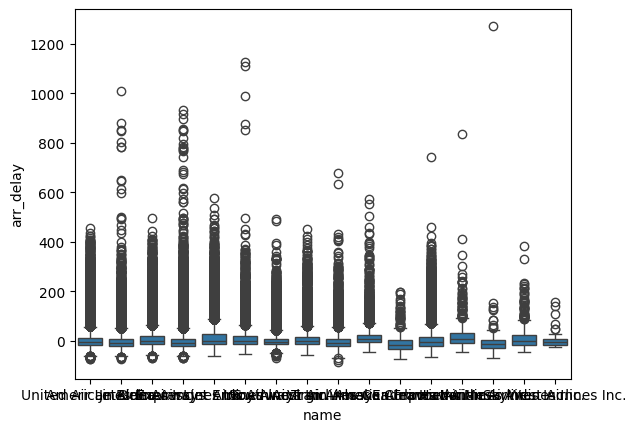

In [16]:
# does arrival delay differ by airline?

sns.boxplot(data=df, x='name', y='arr_delay')

# arrival delay seems uncorrelated with airline


3. Split the sample into an ~80% training set and a ~20% test set.


In [17]:
# code generated with help from chat gpt:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


4. Run a few regressions of your target/outcome variable on a variety of features/predictors. Compute the SSE on the test set.


In [18]:
# code generated with help from chat gpt

# use name (airline name), month (month of the flight) and dep_delay (departure delay in minutes) to predict arr_delay (arrival delay)
# in minutes. The intuition is that colder months might will have grater arrival delays due to weather, airlines might have variation in 
# consistency which causes some to be more delayed on average, and departure delay automatically makes arrival delay larger.

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Split the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Fill missing values in 'dep_delay' with the mean of the column
train_df['dep_delay'].fillna(train_df['dep_delay'].mean(), inplace=True)
test_df['dep_delay'].fillna(train_df['dep_delay'].mean(), inplace=True)

# Fill missing values in 'name' and 'month' with 'Unknown'
train_df['name'].fillna('Unknown', inplace=True)
test_df['name'].fillna('Unknown', inplace=True)
train_df['month'].fillna('Unknown', inplace=True)
test_df['month'].fillna('Unknown', inplace=True)

# Fill missing values in 'arr_delay' with the mean of the column
train_df['arr_delay'].fillna(train_df['arr_delay'].mean(), inplace=True)
test_df['arr_delay'].fillna(train_df['arr_delay'].mean(), inplace=True)

# Encode 'name' and 'month' using one-hot encoding, with one category dropped for baseline
encoder_name = OneHotEncoder(drop='first', handle_unknown='ignore')
encoder_month = OneHotEncoder(drop='first', handle_unknown='ignore')
name_encoded_train = encoder_name.fit_transform(train_df[['name']])
name_encoded_test = encoder_name.transform(test_df[['name']])

month_encoded_train = encoder_month.fit_transform(train_df[['month']])
month_encoded_test = encoder_month.transform(test_df[['month']])

# Create the feature matrix for both training and test sets
X_train = np.hstack([train_df[['dep_delay']].values, name_encoded_train.toarray(), month_encoded_train.toarray()])
X_test = np.hstack([test_df[['dep_delay']].values, name_encoded_test.toarray(), month_encoded_test.toarray()])
y_train = train_df['arr_delay']
y_test = test_df['arr_delay']

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate R^2 and RMSE on the test set
r_squared = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Retrieve the coefficient for 'dep_delay'
dep_delay_coef = model.coef_[0]

# Retrieve the coefficients for each 'month' category
month_category_names = encoder_month.get_feature_names_out(['month'])
month_coefficients = model.coef_[(name_encoded_train.shape[1] + 1):]

# Output results
print(f"R^2 on the test set: {r_squared}")
print(f"RMSE on the test set: {rmse}")
print(f"Coefficient for dep_delay: {dep_delay_coef}")

# Display the coefficients for each month category
print("Coefficients for each month category:")
for month_name, coef in zip(month_category_names, month_coefficients):
    print(f"{month_name}: {coef}")

# Retrieve and display the coefficients for each name category
name_category_names = encoder_name.get_feature_names_out(['name'])
name_coefficients = model.coef_[1:name_encoded_train.shape[1] + 1]
print("Coefficients for each name category:")
for name, coef in zip(name_category_names, name_coefficients):
    print(f"{name}: {coef}")

# the R^2 value is .8, suggesting that 80% of the variation in arrival delay is related to the airline, plane departure time, and
# month that the flight occured. This suggests a high level of predictive accuracy. However, the predictive level might be skewed by the
# inplacing "Unknown" and "average" values to the train and test sets, which i had to do because I was getting errors full null values.

/tmp/ipykernel_5117/2911204914.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['dep_delay'].fillna(train_df['dep_delay'].mean(), inplace=True)
/tmp/ipykernel_5117/2911204914.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(v

R^2 on the test set: 0.8362638853121678
RMSE on the test set: 17.672557612073604
Coefficient for dep_delay: 1.0050059966621046
Coefficients for each month category:
month_2: -1.1785566628447208
month_3: -3.4449623999969843
month_4: 1.209465294954227
month_5: -5.32862223710796
month_6: -0.47787277061608613
month_7: -1.143397679571212
month_8: -2.5419351285684666
month_9: -6.613374055771895
month_10: -2.2929458820575723
month_11: -0.8573000953507401
month_12: 2.2128601615303385
Coefficients for each name category:
name_Alaska Airlines Inc.: -16.54455266557642
name_American Airlines Inc.: -9.373299427675907
name_Delta Air Lines Inc.: -8.698500850503878
name_Endeavor Air Inc.: -10.346197014247249
name_Envoy Air: -1.1068066316411522
name_ExpressJet Airlines Inc.: -5.429029874093554
name_Frontier Airlines Inc.: 0.42100700858180434
name_Hawaiian Airlines Inc.: -12.60647345266294
name_JetBlue Airways: -4.826692995846707
name_Mesa Airlines Inc.: -4.760910228516808
name_SkyWest Airlines Inc.: 0.


5. Which model performed the best, and why?



6. What did you learn?